In [1]:
import pandas
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker
import os
%matplotlib inline

In [2]:
datFileName = "../data/processedSaps-new.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ')
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
sapsDataDF = pandas.concat( [ sapsDataDF, \
                    pandas.cut( sapsDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
sapsDataDF.columns = [ ["dateStr", "hour","sapsLat", \
                     "sapsMLT", "sapsVel", "radId", "poesLat",\
                     "poesMLT", "dst_date", "dst_index", "time", "dst_bin"] ]
# get a csv file with fewer columns for getting grid file data
sapsDataCsv = sapsDataDF[ ["dateStr", "sapsLat", "sapsMLT", "radId", "time"] ]
sapsDataCsv.to_csv("../data/data_for_grid.txt", sep=' ', index=False)
# sapsDataDF["time"] = sapsRawDF["date"].map(lambda x: x.strftime('%H%M'))
sapsDataDF.head()

,dateStr,hour,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,dst_date,dst_index,time,dst_bin
0,20110107,0,56.5,17.7543,308.2077,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"
1,20110107,0,55.5,18.0147,224.1588,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"
2,20110107,0,56.5,17.8749,307.4328,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"
3,20110107,0,55.5,18.1324,222.4787,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"
4,20110107,0,56.5,17.9955,305.4201,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0,"(-25, -10]"


In [3]:
grdFileName = "../data/gridVecs.txt"
prcsdGrdFileName = "../data/gridVecs-processed.txt"
# os.system( 'cat ' + grdFileName + ' | tr -s "  " > ' + "../data/gridVecs-processed.txt" )
inpColNames = [ "dateStr", "time", "sapsLat", "sapsLon", \
          "grdVelMagn", "grdVelAzim", "radId", "sapsMLT"]
gridVecsDF = pandas.read_csv(prcsdGrdFileName, sep=' ',\
                             header=None, names=inpColNames)
gridVecsDF.head()

,dateStr,time,sapsLat,sapsLon,grdVelMagn,grdVelAzim,radId,sapsMLT
0,20110107,0,56.5,344.6231,83.6037,-47.4307,33,17.7543
1,20110107,0,55.5,348.5294,96.6077,-42.6488,33,18.0147
2,20110107,0,56.5,346.4322,84.6154,-44.5228,33,17.8749
3,20110107,0,55.5,350.2941,95.6795,-35.1175,33,18.1324
4,20110107,0,56.5,348.2412,84.6160,-39.3513,33,17.9955


In [4]:
# Merge the grid vectors DF and saps data DF
print "saps DF size-->", sapsDataDF.shape
print "grid DF size before merge-->", gridVecsDF.shape
gridVecsDF = pandas.merge( gridVecsDF, sapsDataDF,\
                          on=[ "dateStr", "time", "sapsLat", "radId", "sapsMLT" ] )
print "grid DF size after merge-->", gridVecsDF.shape

saps DF size--> (173136, 12)
grid DF size before merge--> (167653, 8)
grid DF size after merge--> (163444, 15)


In [5]:
# Assuming a perfectly westward flow for SAPS 
# estimate the velocities inside the channel
sapsAzim = -90.
gridVecsDF["estSapsVels"] = numpy.abs( gridVecsDF["grdVelMagn"]/ numpy.cos( \
                                numpy.deg2rad( sapsAzim - gridVecsDF["grdVelAzim"] ) ) )
# only consider L-o-S velocities greater than 150 m/s
gridVecsDF = gridVecsDF[ gridVecsDF["grdVelMagn"] >= 100. ].reset_index(drop=True)
# filter out all vectors where velocities are greater than 2000 m/s
gridVecsDF["sapsMLTRounded"] = gridVecsDF["sapsMLT"].map(lambda x: round(x) )
gridVecsDF = gridVecsDF[ gridVecsDF["estSapsVels"] <= 2500.].reset_index(drop=True)
gridVecsDF.head()

,dateStr,time,sapsLat,sapsLon,grdVelMagn,grdVelAzim,radId,sapsMLT,hour,sapsVel,poesLat,poesMLT,dst_date,dst_index,dst_bin,estSapsVels,sapsMLTRounded
0,20110107,0,59.5,343.2787,517.6003,-43.2727,33,17.6647,0,404.4858,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",755.101113,18.0
1,20110107,0,57.5,349.7409,104.1324,-30.7649,33,18.0955,0,368.7867,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",203.575813,18.0
2,20110107,0,59.5,345.2459,519.2540,-37.6651,33,17.7958,0,405.7251,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",849.780327,18.0
3,20110107,0,58.5,349.4681,108.4252,-28.0684,33,18.0773,0,404.4406,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",230.434370,18.0
4,20110107,0,57.5,351.6062,124.2545,-23.8893,33,18.2199,0,363.6906,62.0082,18.0,2011-01-07 00:00:00,-18.0,"(-25, -10]",306.823324,18.0


In [6]:
# filter out unwanted data
# Basically those where prob of occ is very less
dstGrps = gridVecsDF.groupby(["dst_bin", "sapsMLTRounded", "sapsLat"])
dstSapsMLTLatCountDF = pandas.DataFrame( dstGrps["sapsVel"].count() ).reset_index()
maxCntMLTLatDst = dstSapsMLTLatCountDF.groupby(["dst_bin"]).max().reset_index()
maxCntMLTLatDst = maxCntMLTLatDst.drop(["sapsMLTRounded", "sapsLat"], 1)
maxCntMLTLatDst.columns = ["dst_bin", "maxCount"]
dstSapsMLTLatCountDF = pandas.merge( dstSapsMLTLatCountDF, maxCntMLTLatDst, \
                              on=["dst_bin"], how='inner')
dstSapsMLTLatCountDF.columns = ["dst_bin", "sapsMLT", "sapsLat", "dataCount", "maxCount"]
dstSapsMLTLatCountDF["probOcc"] = dstSapsMLTLatCountDF["dataCount"]/dstSapsMLTLatCountDF["maxCount"]
# Most likely location plot for dst_bin and MLT
mostLikelyMLTLatLoc = dstSapsMLTLatCountDF.groupby( ["dst_bin", "sapsMLT"] ).max()
# only choose points where prob of occ > 0.25
mostLikelyMLTLatLoc = mostLikelyMLTLatLoc[ mostLikelyMLTLatLoc["probOcc"] >= 0.25 ]
mostLikelyMLTLatLoc.reset_index(inplace=True)
print mostLikelyMLTLatLoc[ mostLikelyMLTLatLoc["dst_bin"] == '(-50, -25]' ].head(20)
mostLikelyMLTLatLoc = pandas.merge( mostLikelyMLTLatLoc, dstSapsMLTLatCountDF,\
                                   on=["dst_bin", "sapsMLT", "dataCount"], how="inner")
mostLikelyMLTLatLoc = mostLikelyMLTLatLoc.drop(["dataCount", \
                        "maxCount_x", "maxCount_y", "probOcc_x", "probOcc_y","sapsLat_x"], 1)
# mostLikelyMLTLatLoc.head()

       dst_bin  sapsMLT  sapsLat  dataCount  maxCount   probOcc
22  (-50, -25]      0.0     63.5        391      1476  0.264905
23  (-50, -25]      1.0     63.5        587      1476  0.397696
24  (-50, -25]     18.0     64.5        458      1476  0.310298
25  (-50, -25]     19.0     64.5        800      1476  0.542005
26  (-50, -25]     20.0     64.5       1090      1476  0.738482
27  (-50, -25]     21.0     64.5       1476      1476  1.000000
28  (-50, -25]     22.0     64.5       1445      1476  0.978997
29  (-50, -25]     23.0     64.5       1211      1476  0.820461


In [7]:
# Get some statistics on SAPS velocities
vestatsSapsGrp = gridVecsDF.groupby(["dst_bin", "sapsMLTRounded"])
meanVelSer = vestatsSapsGrp["estSapsVels"].mean()
stdVelSer = vestatsSapsGrp["estSapsVels"].std()
# merge the two Series into a DF
velstatsSapsDF = pandas.concat([ meanVelSer, stdVelSer], axis=1).reset_index()
velstatsSapsDF.columns = [ "dst_bin", "sapsMLTRounded", "Mean.Vel", "Std.Vel" ]
# merge with mostlikely location DF to choose only the 
# DF where prob of Occ is gt 0.25
velstatsSapsDF = pandas.merge( velstatsSapsDF, mostLikelyMLTLatLoc,
                              left_on=["dst_bin", "sapsMLTRounded"],
                              right_on=["dst_bin", "sapsMLT"], how="inner" )
velstatsSapsDF["sapsMLT"] = velstatsSapsDF["sapsMLT"].astype(int).astype(str)
velstatsSapsDF[ velstatsSapsDF["dst_bin"] == '(-50, -25]' ].head(20)

,dst_bin,sapsMLTRounded,Mean.Vel,Std.Vel,sapsMLT,sapsLat_y
22,"(-50, -25]",0.0,390.386135,233.910766,0,57.5
23,"(-50, -25]",1.0,362.875734,205.570141,1,57.5
24,"(-50, -25]",18.0,640.270287,416.692732,18,62.5
25,"(-50, -25]",19.0,588.562528,349.154295,19,60.5
26,"(-50, -25]",20.0,567.378999,332.358670,20,59.5
27,"(-50, -25]",21.0,546.602331,322.437492,21,59.5
28,"(-50, -25]",22.0,486.705039,298.656762,22,59.5
29,"(-50, -25]",23.0,418.459816,243.104002,23,58.5


     dst_bin  sapsMLTRounded    Mean.Vel     Std.Vel sapsMLT  sapsLat_y
0  (-10, 10]             0.0  401.669780  263.610071       0       61.5
1  (-10, 10]             1.0  397.252862  265.148302       1       61.5
2  (-10, 10]             2.0  379.986290  232.499136       2       61.5
3  (-10, 10]            20.0  476.134539  323.090554      20       64.5
4  (-10, 10]            21.0  492.726485  300.767329      21       63.5


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:3430: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)


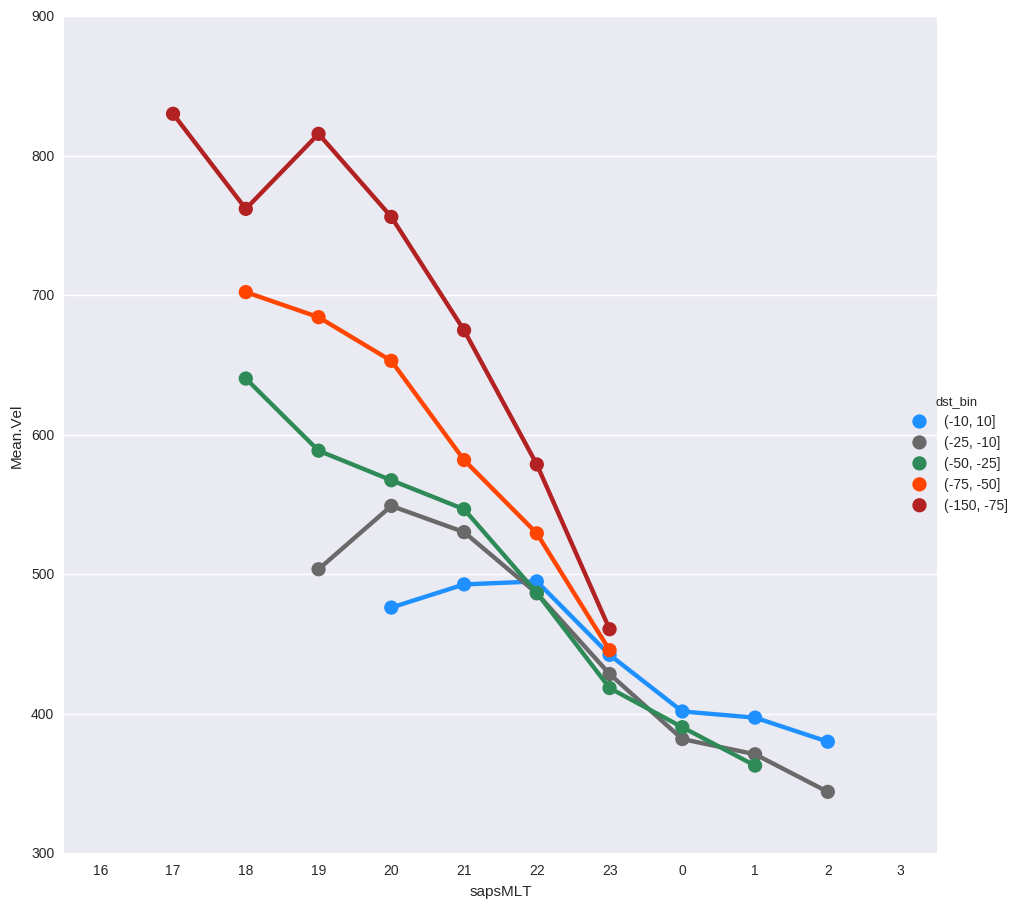

In [8]:
# parameters for plot
mltOrder = [ "16", "17", "18", "19",\
            "20", "21", "22", "23", "0", "1", "2", "3" ]
hue_order=[ '(-150, -75]','(-75, -50]','(-50, -25]', '(-25, -10]', '(-10, 10]' ]
colors = ["dodgerblue","dimgray","seagreen","orangered", "firebrick" ]

print velstatsSapsDF.head()

# velFig = sns.factorplot(x="sapsMLT", y="Mean.Vel", hue="dst_bin", \
#                     data=velstatsSapsDF, hue_order=hue_order[::-1], ci=100.,\
#                    x_order=mltOrder, size=5, aspect=3, \
#                    palette=sns.color_palette(colors), legend_out=True)
velFig = sns.factorplot(x="sapsMLT", y="Mean.Vel", hue="dst_bin", \
                    data=velstatsSapsDF, hue_order=hue_order[::-1], ci=100., \
                   x_order=mltOrder, size=5, aspect=3, \
                   palette=sns.color_palette(colors), legend_out=True)
# velFig.map(plt.errorbar, "sapsMLT", "Mean.Vel", "Std.Vel")
fig2 = velFig.fig
fig2.set_size_inches(10,10)